In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-06-MACHINE-LEARNING-II/master/init.py
import init; init.init(force_download=False);

In [ ]:
pip install scikit-learn --upgrade

     |████████████████████████████████| 22.3MB 1.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error


In [ ]:
datos = pd.read_csv('/content/local/data/timeseries.csv')
del datos['dteday']
del datos['season']
del datos['instant']
del datos['casual']
del datos['registered']
datos.sample(3)

,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
7,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,3
928,0,2,7,0,5,1,1,0.08,0.1667,0.73,0.0000,74
8671,1,1,2,1,1,0,1,0.36,0.3182,0.34,0.4478,7


Extracción de características:

Anexamos 3 caracteristicas tipo binarias de la siguiente manera:
* Separar los datos de poca actividad: 0: para horario de 24:00-06:00, 1: para horario entre las 7:00-23:00, la llamaremos wee_hour
* Tomar el valor correspondiente a si el día anterior fue laboral o no, la llamaremos wrok_ytd
* Tomar el valor correspondiente a si el día siguiente es laboral o no, la llamaremos work_tmr
*Crearemos una característica que muestre la media de: temperatura de los últimos 7 días, 



In [ ]:
class BikeFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self , X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data = _hour_type(data)
        data = _work_days_next(data)
        data = _weathersit_day_next(data)
        data = _rolling_seven_days_cnt(data)
        data =  _rolling_seven_days_temp(data)
        data = _rolling_seven_days_hum(data)
        return data

def _hour_type(data):
    data['hour_type'] = np.where(data['hr']<=6, 0, 1)
    return data

def _work_days_next(data, n_timesteps_lookback = 1 ):
    signal_values = data['workingday'].values
    date_values = data.index
    r = pd.DataFrame(columns = None, index = date_values[n_timesteps_lookback:-1])
    for i in range(1, n_timesteps_lookback+1): 
    #   r['workingday'] = signal_values[n_timesteps_lookback:-1]             
      r[f'workingday_ytd-{i}']= signal_values[n_timesteps_lookback-i:-i-1]
    r['workingday_tmr']= signal_values[n_timesteps_lookback+1:] 
    data = pd.concat([data, r], axis = 1)
    data = data.fillna(data.median())
    return data

def _weathersit_day_next(data, n_timesteps_lookback = 1 ):
    signal_values = data['weathersit'].values
    date_values = data.index
    r = pd.DataFrame(columns = None, index = date_values[n_timesteps_lookback:-1])
    for i in range(1, n_timesteps_lookback+1): 
    #   r['workingday'] = signal_values[n_timesteps_lookback:-1]             
      r[f'weathersit_ytd-{i}']= signal_values[n_timesteps_lookback-i:-i-1]
    r['weathersit_tmr']= signal_values[n_timesteps_lookback+1:] 
    data = pd.concat([data, r], axis = 1)
    data = data.fillna(data.median())
    return data

def _rolling_seven_days_cnt(data, window = 7):
    data['moving_avg_cnt'] = pd.Series(data['cnt']).rolling(window = window).mean()
    data = data.fillna(data.min())
    return data

def _rolling_seven_days_temp(data, window = 7):
    data['moving_avg_temp'] = pd.Series(data['temp']).rolling(window = window).mean()
    data = data.fillna(data.min())
    return data

def _rolling_seven_days_hum(data, window = 7):
    data['moving_avg_hum'] = pd.Series(data['hum']).rolling(window = window).mean()
    data = data.fillna(data.min())
    return data

Selección de principales caracterlisticas con el el coeficiente de correlación de Pearson y separación de features y target

In [ ]:
class FilteredFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, target, value):
        self.value = value
        self.target = target

    def fit(self, X, y =None):
        return self

    def transform(self, X):
        data = X.copy()
        data = _correlation(data, self.value)
        X, y, cols = _separatingXy(data, self.target)
        return X, y, cols

def _correlation(data, value):
    cor = data.corr()
    cor_target = abs(cor['cnt'])
    relevant_features = cor_target[cor_target >value]
    cols = relevant_features.keys().values
    return data[cols]

def _separatingXy(data, target):
    y = data[target]
    X = data.drop(target, axis = 1)
    cols = X.columns
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(X)
    X = scaled
    return X, y, cols

Reservar datos para entrenamiento y test

In [ ]:
class CustomTrainTestSplit(BaseEstimator, TransformerMixin):
    def __init__(self, data):
        self.data = data
        pass

    def fit(self, X, y):
        return self

    def transform(self, X, y ):
        dataset = X.copy()
        train_indices = self.data['yr']==0
        X_train, y_train, X_test, y_test =  dataset[train_indices], y[train_indices], dataset[~train_indices], y[~train_indices]
        return X_train, y_train, X_test, y_test

Preprocesing de los datos

In [ ]:
df = BikeFeatureExtractor().transform(datos)
X, y, features = FilteredFeatures('cnt', 0.28).transform(df)
X_train, y_train, X_test, y_test = CustomTrainTestSplit(df).transform(X,y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8645, 7), (8645,), (8734, 7), (8734,))

Estas fueron las características seleccionadas como las que más se correlacionan con la variable dependiente:

In [ ]:
#Con estas características podremos diseñar el formulario para el despliegue de la aplicación
features

Index(['hr', 'temp', 'atemp', 'hum', 'hour_type', 'moving_avg_cnt',
       'moving_avg_temp'],
      dtype='object')

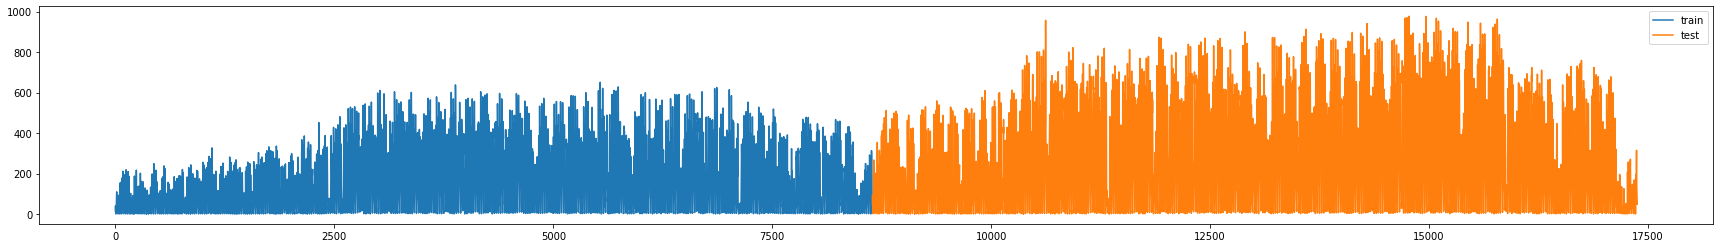

In [ ]:
fig, ax = plt.subplots(figsize = (30,4))
y_train.plot(ax = ax, label = 'train')
y_test.plot(ax = ax, label = 'test')
ax.legend()

In [ ]:
timeSerieSpliter = TimeSeriesSplit(n_splits=5, max_train_size=4)
scorer = make_scorer(mean_absolute_error)

In [ ]:
cross_validate(RandomForestRegressor(), X_train, y_train, scoring = scorer, cv =timeSerieSpliter)

{'fit_time': array([0.14686656, 0.12456799, 0.11658669, 0.12172318, 0.11444497]),
 'score_time': array([0.02009678, 0.01034975, 0.00985003, 0.0093379 , 0.00936699]),
 'test_score': array([ 76.91190278, 163.69088889, 116.16193056, 159.19440972,
        262.37503472])}

Cargo el modelo dentro del Pipeline para pasarlo por el GridSearch

In [ ]:
model = Pipeline([
                  ('clf', RandomForestRegressor())
])

Establezco los parámetros del GridSearch para la búsqueda de los mejores parámetros:

In [ ]:
param_grid = {
        'clf__max_depth': [2,3,5, 6, 8, 10, 13],
        'clf__criterion': ['mse', 'mae'],
        'clf__max_features': ['auto', 'sqrt', 'log2'] 
}

Instancio el GridSearchCV:

In [ ]:
grid_search = GridSearchCV(
    model, 
    param_grid = param_grid,
    cv = timeSerieSpliter
)

Entreno el Grid para extraer los mejores parámetros:

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=4, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('clf', RandomForestRegressor())]),
             param_grid={'clf__criterion': ['mse', 'mae'],
                         'clf__max_depth': [2, 3, 5, 6, 8, 10, 13],
                         'clf__max_features': ['auto', 'sqrt', 'log2']})

Estos on los mejores parámetros para el RandomForesregressor:

In [ ]:
grid_search.best_params_

{'clf__criterion': 'mae', 'clf__max_depth': 13, 'clf__max_features': 'log2'}

Ajusto de nuevo el modelo con los mejores parámetros:

In [ ]:
clf = RandomForestRegressor(max_depth=13, criterion='mae', max_features='log2')
clf.fit(X_train, y_train)

RandomForestRegressor(criterion='mae', max_depth=13, max_features='log2')

Ahora hacemos predicciones y medimos el error

In [ ]:
y_pred = clf.predict(X_test)
mean_absolute_error(y_test, y_pred)

85.15587645981223

In [ ]:
clf.score(X_test, y_test)

0.6134656635478459

Hacemos una prediccion de un solo dato al azar:

In [ ]:
idxs = np.random.permutation(len(X_test))[:1]
y_pred = clf.predict(X_test[idxs].reshape(1,-1))
y_true= y_test.values[idxs]
y_pred, y_true, mean_absolute_error(y_true, y_pred)

(array([159.31]), array([238]), 78.69)

Ahora me interesa saber cómo son las predicciones si entreno con toda la información del dataset:

In [ ]:
clf2 = RandomForestRegressor(max_depth=10, criterion='mse', max_features='sqrt')
clf2.fit(X,y)

RandomForestRegressor(max_depth=10, max_features='sqrt')

In [ ]:
inputs = np.random.sample(7).reshape(1,-1)
clf2.predict(inputs)

array([278.83309073])

Ahora vamos a aprovechar el modelo entrenado para hacer predicciones en un servidor

In [ ]:
joblib.dump(clf,'trained_model_3.pkl')


['trained_model_3.pkl']

In [ ]:
joblib.dump(clf2,'full_trained_model_3.pkl')

['full_trained_model_3.pkl']